In [ ]:
import numpy as np
from scipy.fftpack import dctn
from scipy.fftpack import idctn
import cv2
from google.colab.patches import cv2_imshow
import os
import matplotlib.pyplot as plt
from PIL import Image
from scipy.io import loadmat
from skimage.metrics import structural_similarity as ssim_function
from skimage import io, color
import torch
from torchvision import transforms
from scipy.stats import spearmanr
from scipy.optimize import curve_fit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **JPEG Implementation**

### Loading Image

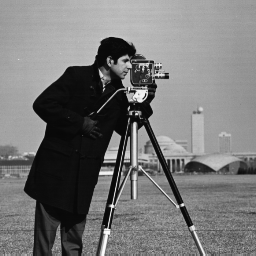

In [ ]:
image = cv2.imread('/content/cameraman.tif')
img = cv2.imread('/content/cameraman.tif', cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

### JPEG Implementation

**1. DCT Transform**

In [ ]:
def compute_dct_block(block):
    dct_block = dctn(block, type=2, norm='ortho')
    return dct_block

def compute_dct_image(image):
    block_size = 8
    num_blocks_rows = image.shape[0] // block_size
    num_blocks_cols = image.shape[1] // block_size
    dct_coefficients = np.zeros_like(image)

    for i in range(num_blocks_rows):
        for j in range(num_blocks_cols):
            block = image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            dct_block = compute_dct_block(block)
            dct_coefficients[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = dct_block
    return dct_coefficients

In [ ]:
def inverse_dct_block(block):
    reconstructed_block = idctn(block, type=2, norm='ortho')
    return reconstructed_block

def inverse_dct_image(dct_image):
    block_size = 8
    num_blocks_rows = dct_image.shape[0] // block_size
    num_blocks_cols = dct_image.shape[1] // block_size
    image = np.zeros_like(dct_image)

    for i in range(num_blocks_rows):
        for j in range(num_blocks_cols):
            dct_block = dct_image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            image_block = inverse_dct_block(dct_block)
            image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = image_block
    return image

**2. Quantisation**

In [ ]:
Q = [[16, 11, 10, 16, 24, 40, 51, 61],
     [12, 12, 14, 19, 26, 58, 60, 55],
     [14, 13, 16, 24, 40, 57, 69, 56],
     [14, 17, 22, 29, 51, 87, 80, 62],
     [18, 22, 37, 56, 68, 109, 103, 77],
     [24, 35, 55, 64, 81, 104, 113, 92],
     [49, 64, 78, 87, 103, 121, 120, 101],
     [72, 92, 95, 98, 112, 100, 103, 99]]

In [ ]:
def quantize_dct_block(X, Q):
    Y = (X / Q + 0.5)
    Y = np.floor(Y)
    return Y

def reconstruction_block(Y, Q):
    X = Y*Q
    return X

In [ ]:
def quantised_image(image, Q):
    block_size = 8
    num_blocks_rows = image.shape[0] // block_size
    num_blocks_cols = image.shape[1] // block_size
    quant_image = np.zeros_like(image)

    for i in range(num_blocks_rows):
        for j in range(num_blocks_cols):
            block = image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            quant_block = quantize_dct_block(block, Q)
            quant_image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = quant_block
    return quant_image

def reconstruct_img(quant_img, Q):
    block_size = 8
    num_blocks_rows = image.shape[0] // block_size
    num_blocks_cols = image.shape[1] // block_size
    image = np.zeros_like(quant_img)
    for i in range(num_blocks_rows):
        for j in range(num_blocks_cols):
            quant_block = image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            block = reconstruction_block(quant_block, Q)
            image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = block
    return image

**3. Loss-Less Huffman Encoding**

In [ ]:
def zigzag_traversal(array):
    zigzag_ordered = []
    for i in range(8):
        if i % 2 == 0:
            for j in range(i + 1):
                zigzag_ordered.append(array[i - j][j])
        else:
            for j in range(i + 1):
                zigzag_ordered.append(array[j][i - j])
    for i in range(1, 8):
        if i % 2 == 0:
            for j in range(8 - i):
                zigzag_ordered.append(array[7 - j][i + j])
        else:
            for j in range(8 - i):
                zigzag_ordered.append(array[i + j][7 - j])
    return zigzag_ordered

In [ ]:
def reverse_zigzag_traversal(zigzag_ordered):
    array = np.zeros((8, 8), dtype=np.int32)
    index = 0
    for i in range(8):
        if i % 2 == 0:
            for j in range(i + 1):
                array[i - j][j] = zigzag_ordered[index]
                index += 1
        else:
            for j in range(i + 1):
                array[j][i - j] = zigzag_ordered[index]
                index += 1
    for i in range(1, 8):
        if i % 2 == 0:
            for j in range(8 - i):
                array[7 - j][i + j] = zigzag_ordered[index]
                index += 1
        else:
            for j in range(8 - i):
                array[i + j][7 - j] = zigzag_ordered[index]
                index += 1
    return array

In [ ]:
def encode_index(index):
    if index == 0:
        return "0"
    elif index == -1 or index == 1:
        return "10" + bin(index & 1)[2:]
    elif -3 <= index <= 3:
        return "110" + bin(index & 3)[2:].zfill(2)
    elif -7 <= index <= 7:
        return "1110" + bin(index & 7)[2:].zfill(3)
    elif -15 <= index <= 15:
        return "11110" + bin(index & 15)[2:].zfill(4)
    elif -31 <= index <= 31:
        return "111110" + bin(index & 31)[2:].zfill(5)
    elif -63 <= index <= 63:
        return "1111110" + bin(index & 63)[2:].zfill(6)
    elif -127 <= index <= 127:
        return "11111110" + bin(index & 127)[2:].zfill(7)
    elif -255 <= index <= 255:
        return "111111110" + bin(index & 255)[2:].zfill(8)
    elif -512 <= index <= 512:
        return "1111111110" + bin(index & 511)[2:].zfill(9)
    else:
        return None

def encode_huffman(arr):
  encoded_output = ""
  for num in arr:
      encoded_output += encode_index(num)
  return encoded_output

**4. Final Functions**

In [ ]:
def jpeg_block(block, Q):
    block = block.astype(np.int32)
    block = block - 128
    dct_coeff = compute_dct_image(block)
    quant_coeff = quantised_image(dct_coeff, Q)
    linear_quant_coeff = zigzag_traversal(quant_coeff)
    encodings = encode_huffman(linear_quant_coeff)
    return encodings, quant_coeff

def jpeg_image_compression(image, Q):
    block_size = 8
    num_blocks_rows = image.shape[0] // block_size
    num_blocks_cols = image.shape[1] // block_size
    bitstream = ""
    compressed_image = np.zeros_like(image)

    for i in range(num_blocks_rows):
        for j in range(num_blocks_cols):
            block = image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            block_enc, block_coeff = jpeg_block(block, Q)
            block_coeff = reconstruction_block(block_coeff, Q)
            block_coeff = inverse_dct_block(block_coeff)
            block_coeff = block_coeff + 128
            block_coeff = block_coeff.astype(np.uint8)
            compressed_image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = block_coeff
            bitstream = bitstream + block_enc
    return bitstream, compressed_image

### RESULTS and Comparisons

In [ ]:
bitstream, compressed_image = jpeg_image_compression(img, Q)

In [ ]:
cv2.imwrite('/content/compressed_cameraman.jpeg', compressed_image)

True

In [ ]:
image_path = "/content/cameraman.tif"
image_size_bytes = os.path.getsize(image_path)
image_size_kb = image_size_bytes / 1024
print("Size of the Original image file:", image_size_kb, "KB")

num_bytes = len(bitstream) // 8
size_kb = num_bytes / 1024
print("Size of the binary string:", size_kb, "KB")

compressed_image_path = "/content/compressed_cameraman.jpeg"
compressed_image_size_bytes = os.path.getsize(compressed_image_path)
compressed_size_kb = compressed_image_size_bytes / 1024
print("Size of the compressed image file:", compressed_size_kb, "KB")

MSE_imp = np.mean((img-compressed_image)**2)
print(f'MSE: {MSE_imp:.4f}')

Size of the Original image file: 63.7109375 KB
Size of the binary string: 12.701171875 KB
Size of the compressed image file: 17.8486328125 KB
MSE: 26.1751


### Comparison with Standard Library Function

In [ ]:
mse_arr = []
size_arr = []
for i in range(10,101):
  jpeg_quality = i
  _, compressed_image_buffer = cv2.imencode('.jpg', img, [cv2.IMWRITE_JPEG_QUALITY, jpeg_quality])
  std_comp = cv2.imdecode(compressed_image_buffer, cv2.IMREAD_GRAYSCALE)

  MSE = np.mean((img-std_comp)**2)
  size = std_comp.nbytes/1024
  mse_arr.append(MSE)
  size_arr.append(size)

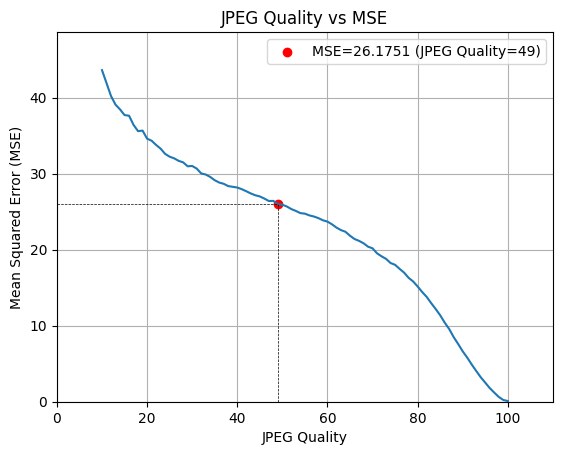

In [ ]:
plt.plot(range(10, 101), mse_arr)
plt.xlabel('JPEG Quality')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('JPEG Quality vs MSE')
plt.grid(True)
index = mse_arr.index(min(mse_arr, key=lambda x: abs(x - MSE_imp)))
plt.scatter(index + 10, mse_arr[index], color='red', label=f'MSE={MSE_imp:.4f} (JPEG Quality={index+10})')
plt.plot([index + 10, index + 10], [0, mse_arr[index]], 'k--', linewidth=0.5)
plt.plot([0, index + 10], [mse_arr[index], mse_arr[index]], 'k--', linewidth=0.5)
plt.xlim(0, 110)
plt.ylim(0, max(mse_arr) + 5)
plt.legend()
plt.show()

### PLOTS

In [ ]:
original_image_path = "/content/cameraman.tif"
original_image = Image.open(original_image_path)

compressed_image_path = "compressed_cam_standard.jpeg"
original_image.save(compressed_image_path, quality=49)

std_size_bytes = os.path.getsize(compressed_image_path)
std_size_kb = std_size_bytes / 1024

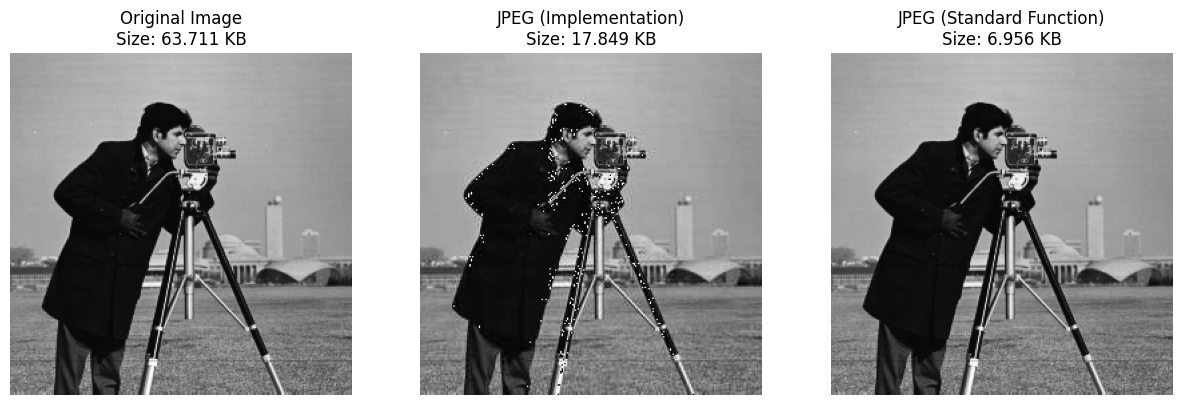

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title(f'Original Image\nSize: {image_size_kb:.3f} KB')
axs[1].imshow(cv2.cvtColor(compressed_image, cv2.COLOR_BGR2RGB))
axs[1].set_title(f'JPEG (Implementation)\nSize: {compressed_size_kb:.3f} KB')
axs[2].imshow(cv2.cvtColor(std_comp, cv2.COLOR_BGR2RGB))
axs[2].set_title(f'JPEG (Standard Function)\nSize: {std_size_kb:.3f} KB')
for ax in axs:
    ax.axis('off')
plt.show()